<a href="https://colab.research.google.com/github/JonathaCosta/3_SmartGrid/blob/main/TS/resumo_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise em Time Série
Compactação

## Sumário

Classe de métodos para previsão utilizando modelos AR,ARMA,ARIMA,SARIMA


Utiliza as bibliotecas:
* import matplotlib.pyplot as plt
* from statsmodels.tsa.ar_model import AR
* from statsmodels.tsa.arima_model import ARMA,ARIMA
* from statsmodels.tsa.statespace.sarimax import SARIMAX

Utiliza o dataset: https://raw.githubusercontent.com/JonathaCosta/1_Notebooks/main/Datasets/timeline.csv'

# Classes


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX



class AnalisePrevisao():

  def __init__(self,dados:str,index_col:None, coluna_analise:str):
     # Método init dados e a coluna que será utilizada como index.
    self.dados = dados
    self.df = pd.read_csv(self.dados, index_col = index_col, parse_dates=True, infer_datetime_format=True )    
    self.coluna_analise = coluna_analise

     # Separação do conjunto de dados para teste e treinamentos    
    corte = int(len(self.df)*2/3) 
    self.train_set = self.df[coluna_analise][:corte]
    self.test_set  = self.df[coluna_analise][corte:] 
    
    # Futuro
    self.periodo_futuro = self.df.index[-1] + np.timedelta64(1,'D')
   

  def ar(self, freq:str,n=3,graf = 0):
    # Modelo ar e teste e 'n' configurações    
    ar = AR(self.train_set, freq= freq).fit(n)
    
    # Recebe os parâmetros do modelo treinado e aplica no conjunto de teste
    previsoes = ar.params[0]
    for i,coef in enumerate(ar.params[1:]):
      previsoes+= coef * self.test_set.shift(i+1)
    erro = round((((self.test_set - previsoes)**2).mean())**0.5,2)
   
    if graf==1:
      self.graf('AR',previsoes,erro,n)
    else: 
      None  

    return erro , previsoes 

  def arma(self,freq:str, graf = 0):
    # Modelo arma e teste e 'n' configurações
    configs = [(4,4),(4,3),(4,2),(4,1),
               (3,4),(3,3),(3,2),(3,1),
               (2,4),(2,3),(2,2),(2,1),
               (1,4),(1,3),(1,2),(1,1)]
    best = 1000

    # Modelo aprende os parâmetro em trains_set e testa-os em test_set
    for i in configs:
      try:
        arma_train = ARMA(self.train_set, freq=freq, order = i).fit()
        arma_test = ARMA(self.test_set, freq=freq, order = i).fit(arma_train.params)
        erro = round(((arma_test.resid **2).mean())**0.5,2)
        if erro < best:
           best = erro
           print(i,erro,arma_test.predict()[0])
           
      except:    
        pass
    
    
    previsoes = arma_test.predict()
    forecast = arma_test.predict(start=self.periodo_futuro.day ,end=self.periodo_futuro.day)

    if graf==1:
      self.graf('ARMA',previsoes,best,i)
    else: 
      None  

    return erro, previsoes,forecast 

  def arima(self,freq:str, graf = 0):
    # Modelo arima e teste e 'n' configurações
    configs = [(3,1,3),(3,1,2),(3,1,1),(3,1,0),
               (2,1,3),(2,1,2),(2,1,1),(2,1,0),
               (1,1,3),(1,1,2),(1,1,1),(1,1,0),               
               ]
    best = 1000

    # Modelo aprende os parâmetro em trains_set e testa-os em test_set
    for i in configs:
      try:
        arima_train = ARIMA(self.train_set, freq=freq, order = i).fit()
        arima_test = ARIMA(self.test_set, freq=freq, order = i).fit(arima_train.params)
        erro = round(((arima_test.resid **2).mean())**0.5,2)
        if erro < best:
           best = erro
           print(i,erro,arima_test.predict(typ='levels')[0])
           
      except:    
        print('fail')
        pass
    previsoes = arima_test.predict(typ='levels')
    forecast = arima_test.predict(start=self.periodo_futuro.day ,end=self.periodo_futuro.day)

    if graf==1:
      self.graf('ARIMA',previsoes,best,i)
    else: 
      None  

    return erro, previsoes,forecast 

  def sarima(self,freq:str, graf = 0):
    # Modelo sarima e teste e 'n' configurações
    configs = [(3,1,3),(3,1,2),(3,1,1),(3,1,0),
               (2,1,3),(2,1,2),(2,1,1),(2,1,0),
               (1,1,3),(1,1,2),(1,1,1),(1,1,0),               
               ]
    best = 1000

    # Modelo aprende os parâmetro em trains_set e testa-os em test_set
    for i in configs:
      try:
        sarima_train = SARIMAX(self.train_set, freq=freq, order = i,seasonal_order=(3,1,2,12)).fit()
        sarima_test = SARIMAX(self.test_set, freq=freq, order = i,seasonal_order=(3,1,2,12)).fit(sarima_train.params)
        erro = round(((sarima_test.resid **2).mean())**0.5,2)
        if erro < best:
           best = erro
           print(i,erro,sarima_test.predict(typ='levels')[0])
           
      except:    
        print('fail')
        pass
    previsoes = sarima_test.predict(typ='levels')
    forecast = sarima_test.predict(start=self.periodo_futuro.day ,end=self.periodo_futuro.day)

    if graf==1:
      self.graf('SARIMA',previsoes,best,i)
    else: 
      None  

    return erro, previsoes,forecast 
 
  def graf(self, metodo:str, previsoes, erro, n=None, forecast=None):
    # Opção de análise gráfica com datasérie diferentes
      plt.figure()
      self.train_set.plot()
      self.test_set.plot()
      previsoes.plot(figsize=(15,6),grid=True)
      plt.title(f"Modelo e previsões para '{self.coluna_analise}' com {metodo} e config: {n}. RMSE: {erro}")
      plt.legend(['Treino','Teste','Previsão'])
    

    

# Simulação

In [1]:
dados='https://raw.githubusercontent.com/JonathaCosta/1_Notebooks/main/Datasets/timeline.csv'

coluna, freq = 'diet','MS'
s = AnalisePrevisao(dados,'month',coluna)
erro, previsoes = s.ar(freq,3,1)   # Coluna de análise, frequencia da série, número de lags (default = 3) e resposta gráfica (0 ou 1)



NameError: ignored

(4, 1) 4.61 47.23497648617088
(1, 4) 4.6 47.12602056048839


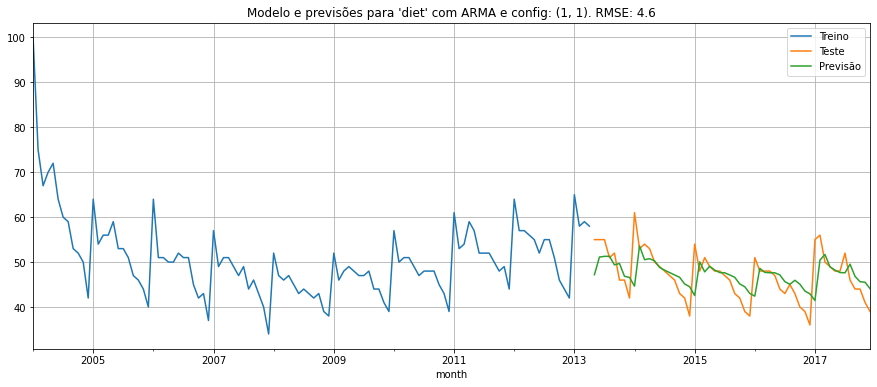

In [ ]:
erro,previsoes,forecast = s.arma(freq,1)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(3, 1, 3) 4.37 54.85629758165982


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist

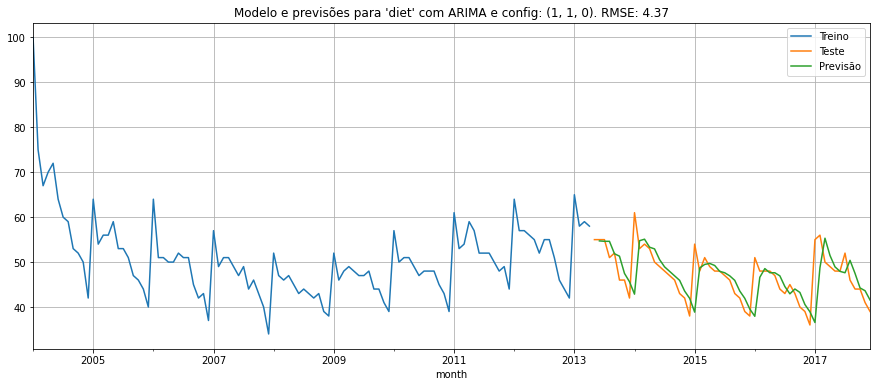

In [ ]:
erro,previsoes,forecast = s.arima(freq,1)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1, 3) 9.12 0.0


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimiza

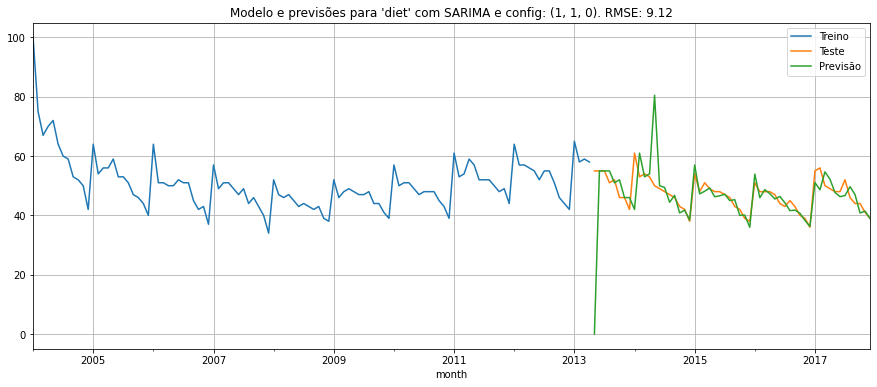

In [ ]:
erro,previsoes,forecast = s.sarima(freq,1)